# Week 1

### The problem:
Pete lives in Chicago, Illinois. He has an extra bedroom in his home that he decides to rent out on AirBNB for extra income. The problem is that Pete has no idea how much to charge per night. If he charges too much people would rather live in more affordable spaces. If he charges too little he may be missing out on profits or giving potential visitors the idea that there's something wrong with the place, causing it to be cheap.


Pete doesn't know what the coordinates of his house are, he only knows the address, so we use Foursquare to find his latitude and longitude:

In [3]:
address = '3027 Warren Blvd, Chicago, IL'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)


41.8817172 -87.70236188054187


### The Solution:
We can use the data provided by AirBNB and Foursquare to predict the best pricing for Pete's guest room based on his location. All AirBNB data is available on [insideairbnb](http://insideairbnb.com/).
The data for Chicago can be downloaded from [here](http://data.insideairbnb.com/united-states/il/chicago/2021-07-10/visualisations/listings.csv)


### The Dataset:

First, we install the necessary libraries:

In [1]:
!pip install --user pandas==1.0.3
import pandas as pd
pd.__version__
!pip install folium
!pip install requests

!pip install geolocator
import geopy
from geopy.geocoders import Nominatim
import numpy as np
import requests
import folium
from pandas.io.json import json_normalize
import json

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


     |████████████████████████████████| 10.0 MB 15.3 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.18.0 requires nose, which is not installed.
hdijupyterutils 0.18.0 requires jupyter>=1, which is not installed.
hdijupyterutils 0.18.0 requires nose, which is not installed.
     |████████████████████████████████| 94 kB 5.0 MB/s  eta 0:00:01
  Created wheel for geolocator: filename=geolocator-0.1.1-py3-none-any.whl size=12166 sha256=308a1209cd2cb6386fcb86d83d6adff10cdb49d9a69ea1af8b5a33e3933d6669
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/ae/03/0b/d4576e192ac4dba26228b05efc2aa7e75ca22fa2677e691307
Successfully built geolocator


Then load the data into a DataFrame:

In [2]:
df = pd.read_csv('http://data.insideairbnb.com/united-states/il/chicago/2021-07-10/visualisations/listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,Hyde Park - Walk to University of Chicago,2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,85,1,185,2021-06-21,2.45,1,338
1,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90166,-87.68021,Entire home/apt,65,2,401,2021-05-22,3.32,1,59
2,10945,The Biddle House (#1),33004,At Home Inn,NaN,Lincoln Park,41.91196,-87.63981,Entire home/apt,143,4,28,2021-06-21,0.32,10,102
3,12068,Chicago GOLD COAST 1 Bedroom Condo,40731,Dominic,NaN,Near North Side,41.90491,-87.63213,Entire home/apt,99,7,11,2021-05-09,0.14,1,242
4,12140,Lincoln Park Guest House,46734,Sharon And Robert,NaN,Lincoln Park,41.92357,-87.64947,Private room,329,2,7,2021-07-06,0.10,1,165


In [3]:
print(df['neighbourhood_group'])

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6361   NaN
6362   NaN
6363   NaN
6364   NaN
6365   NaN
Name: neighbourhood_group, Length: 6366, dtype: float64


We see that the entire neigbourhood_group column consists of 'NaN' , so we can delete that column. 
We can also delete the id, host_id and host_name columns and review columns since they're not relevant to the price or location.

In [3]:
df.drop(columns=['id', 'host_id', 'host_name', 'neighbourhood_group', 'number_of_reviews', 'last_review', 'reviews_per_month'], inplace=True, axis=1)
df.head()

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,Hyde Park - Walk to University of Chicago,Hyde Park,41.78790,-87.58780,Private room,85,1,1,338
1,Tiny Studio Apartment 94 Walk Score,West Town,41.90166,-87.68021,Entire home/apt,65,2,1,59
2,The Biddle House (#1),Lincoln Park,41.91196,-87.63981,Entire home/apt,143,4,10,102
3,Chicago GOLD COAST 1 Bedroom Condo,Near North Side,41.90491,-87.63213,Entire home/apt,99,7,1,242
4,Lincoln Park Guest House,Lincoln Park,41.92357,-87.64947,Private room,329,2,1,165


The dataframe now has 6,366 rows and 9 columns:

In [7]:
df.shape

(6366, 9)

We can remove all the rows containing anything other than "Private room" in the room_type column since that's the type of property we're working with.

In [4]:
df= df[df['room_type'] == 'Private room']
df.head(10)

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,Hyde Park - Walk to University of Chicago,Hyde Park,41.78790,-87.58780,Private room,85,1,1,338
4,Lincoln Park Guest House,Lincoln Park,41.92357,-87.64947,Private room,329,2,1,165
9,Andersonville - Perfect location!,Uptown,41.97303,-87.66567,Private room,110,3,2,0
11,"Rest, Relax and Explore",West Town,41.89615,-87.67934,Private room,63,2,2,153
12,The Explorer Room,West Town,41.89615,-87.67934,Private room,55,2,2,222
13,"Near Lake, Wrigley and Weiss Hospital",Uptown,41.96852,-87.65225,Private room,35,3,1,95
18,Darling Damen Dwelling (with bike if you like),North Center,41.95888,-87.67776,Private room,35,3,1,93
21,Huge Bedroom with pvt marble bath,Uptown,41.96313,-87.66235,Private room,125,365,3,365
26,Logan Square Classic Bungalow,Logan Square,41.92666,-87.70601,Private room,103,2,1,223
28,"30 Day+ Med student, interns & interim stays.",Edgewater,41.97806,-87.65676,Private room,35,30,1,312


This dataframe now has 1,669 rows and 9 columns:

In [9]:
df.shape

(1669, 9)

Map of all these AirBNB properties in Chicago:

(In case you are viewing this on Github and the maps aren't showing, you can [click here](https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/f804da71-a450-4b5b-b2db-91a9ebd7349e/view?access_token=8eadf1ac889aac2e80a7f5ae182f7c670acf52ebd000c67f81e24d611015a5e6) to view the notebook on IBM Watson instead.)

In [5]:
chi_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

for latitude, longitude in zip(df.latitude, df.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(chi_map)

    
folium.Marker([41.8817172, -87.70236188054187], popup="Pete's House").add_to(chi_map)
chi_map.add_child(folium.ClickForMarker(popup="Waypoint"))

# display map
chi_map

In [6]:
#We see that Pete's property is in East Garfield Park, so we find the minimum, maximum and average price for AirBNBs in his neighbourhood:

df_eastgar = df[df['neighbourhood'] == 'East Garfield Park']
df_eastgar

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
75,Modern Guest Bedroom Room in Designers House,East Garfield Park,41.88538,-87.69801,Private room,101,3,1,251
175,"Clean, Quiet, Private Room with private bathroom",East Garfield Park,41.88152,-87.69768,Private room,45,7,2,138
469,"Teal Room - King Bed, near CTA, 20min to Downtown",East Garfield Park,41.88302,-87.70960,Private room,56,1,9,346
657,"""Wine"" Room - 1 block from train, Victorian Charm",East Garfield Park,41.88302,-87.70960,Private room,49,1,9,309
679,"Vintage Airline - Close to Train, Full Size Bed",East Garfield Park,41.88302,-87.70960,Private room,44,1,9,337
...,...,...,...,...,...,...,...,...,...
6146,4C1c Luxury Double Full Beds in Chicago,East Garfield Park,41.87900,-87.70291,Private room,50,1,16,347
6207,Charming Master bedroom with private bath,East Garfield Park,41.87046,-87.69518,Private room,87,32,4,51
6251,Charming private bedroom,East Garfield Park,41.87203,-87.69489,Private room,87,32,4,64
6252,Charming Master bedroom with private bath-s,East Garfield Park,41.87122,-87.69506,Private room,87,32,4,50


In [8]:
df_eastgar.describe()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,41.879313,-87.702297,58.121622,10.743243,11.189189,213.067568
std,0.004338,0.006959,47.823578,13.841629,8.334901,143.753435
min,41.869720,-87.720560,22.000000,1.000000,1.000000,0.000000
25%,41.876855,-87.707328,39.000000,1.000000,4.000000,65.500000
50%,41.878945,-87.702440,45.000000,2.000000,9.000000,307.000000
75%,41.883020,-87.695543,53.750000,32.000000,16.000000,342.250000
max,41.887900,-87.693270,311.000000,32.000000,25.000000,365.000000


In [7]:
df.describe()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365
count,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,41.889061,-87.667899,87.591971,7.117436,5.594967,153.411025
std,0.069594,0.046831,270.804317,24.704816,7.117724,134.177895
min,41.651740,-87.830610,16.000000,1.000000,1.000000,0.000000
25%,41.849740,-87.695220,41.000000,1.000000,1.000000,10.000000
50%,41.892130,-87.667330,55.000000,2.000000,3.000000,131.000000
75%,41.942480,-87.633210,85.000000,3.000000,7.000000,303.000000
max,42.022200,-87.535880,9999.000000,500.000000,52.000000,365.000000


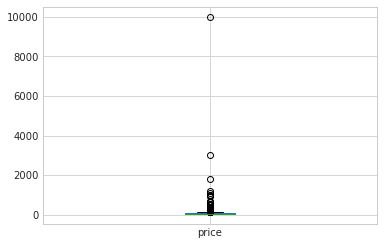

In [8]:
#From the boxplot below we see that there probably are some outliers

prices = df['price']
prices = prices.to_frame()
bp = prices.boxplot()

In [7]:
#Removing the outliers:

Q1 = 41
Q3 = 85
IQR = Q3-Q1
lower_bound = Q1 - (IQR*1.5)
upper_bound = Q3 + (IQR*1.5)

df = df[df['price'] <= upper_bound]
df = df[df['price'] >= lower_bound]

In [8]:
df.describe()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365
count,1544.000000,1544.000000,1544.000000,1544.000000,1544.000000,1544.000000
mean,41.888254,-87.669315,61.246114,6.966321,5.456606,152.711788
std,0.070870,0.047632,28.350670,22.063836,6.811559,133.893663
min,41.651740,-87.830610,16.000000,1.000000,1.000000,0.000000
25%,41.847313,-87.696577,40.000000,1.000000,1.000000,10.000000
50%,41.890420,-87.668300,54.000000,2.000000,3.000000,130.000000
75%,41.943065,-87.640145,75.000000,3.000000,7.000000,301.250000
max,42.022200,-87.535880,151.000000,500.000000,52.000000,365.000000


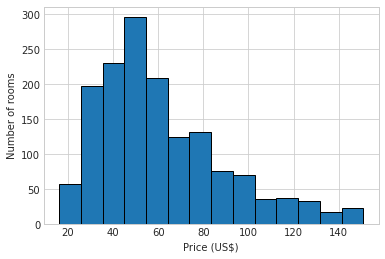

In [13]:
x = df['price']

figure = plt.figure()
plt.hist(x, bins =14, edgecolor='black')
plt.xlabel('Price (US$)')
plt.ylabel('Number of rooms')
plt.show()

In [9]:
df_above_40 = df[df['price']>=40]
df_above_80 = df[df['price']>=80]
df_above_101 = df[df['price']>=101]

df_0_39 = df[df['price']<=39.99]  #green
df_40_79 = df_above_40[df_above_40['price']<=79.99] #yellow
df_80_100 = df_above_80[df_above_80['price']<=100.99]  # orange
df_101_139 = df_above_101[df_above_101['price']<=139.99] #red
df_above_140 = df[df['price']>=140]  #black 


In [10]:
map_all = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

#Properties below $39 per night:
for latitude, longitude in zip(df_0_39.latitude, df_0_39.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=4,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
        ).add_to(map_all)

#Properties from $40 to $79 per night:
for latitude, longitude in zip(df_40_79.latitude, df_40_79.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=4,
        fill=True,
        color='yellow',
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(map_all)    

#Properties from $80 to $100 per night:
for latitude, longitude in zip(df_80_100.latitude, df_80_100.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=4,
        fill=True,
        color='orange',
        fill_color='orange',
        fill_opacity=0.6
        ).add_to(map_all)

#Properties from $101 to $139 per night
for latitude, longitude in zip(df_101_139.latitude, df_101_139.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=4,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
        ).add_to(map_all)

#Properties above $140 per night:
for latitude, longitude in zip(df_above_140.latitude, df_above_140.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=4,
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.6
        ).add_to(map_all)
    
folium.Marker([41.8817172, -87.70236188054187], popup="Pete's House").add_to(map_all)
map_all.add_child(folium.ClickForMarker(popup="Waypoint"))

# display map
map_all

In [ ]:
google_code = '3PLCRPKIIWUCZHK5XZRJ10PSWSBIX5JG2GAZR220P1PDXUI5#_=_'
CLIENT_ID = '3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L'
access_token = 'FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS'

In [11]:
url = 'https://api.foursquare.com/v2/venues/search?client_id=3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L&client_secret=A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5&ll=41.8890,-87.6655&oauth_token=FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS&v=20180604&categoryId&radius=250&limit=30'
results = requests.get(url).json()

In [12]:
results

{'meta': {'code': 200, 'requestId': '6180bcf703526372ff0753ff'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '51657fa7e4b0764fd983b406',
    'name': 'Ignite Glass Studios',
    'location': {'address': '401 N Armour St',
     'crossStreet': '(Between Hubbard St and W Kinzie St)',
     'lat': 41.88903703326923,
     'lng': -87.6652382176673,
     'labeledLatLngs': [{'label': 'display',
       'lat': 41.88903703326923,
       'lng': -87.6652382176673}],
     'distance': 22,
     'postalCode': '60642',
     'cc': 'US',
     'city': 'Chicago',
     'state': 'IL',
     'country': 'United States',
     'formattedAddress': ['401 N Armour St ((Between Hubbard St and W Kinzie St))',
      'Chicago, IL 60642',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1e2931735',
      'name': 'Art Gallery',
      'pluralName': 'Art Galleries',
      'shortName': 'Art Gallery',
      'icon': {'prefix': 'https://ss3.4sqi.net

In [23]:
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-23-1cb4c0e6f6f4>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.state,location.country,location.formattedAddress,venuePage.id,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,51657fa7e4b0764fd983b406,Ignite Glass Studios,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1635745878,False,401 N Armour St,(Between Hubbard St and W Kinzie St),41.889037,-87.665238,"[{'label': 'display', 'lat': 41.88903703326923...",...,IL,United States,[401 N Armour St ((Between Hubbard St and W Ki...,67823254,NaN,NaN,NaN,NaN,NaN,NaN
1,5c26770535d3fc003912a667,Altitude Trampoline Park,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",v-1635745878,False,404 N Ashland Ave,NaN,41.889144,-87.665766,"[{'label': 'display', 'lat': 41.889144, 'lng':...",...,IL,United States,"[404 N Ashland Ave, Chicago, IL 60642, United ...",591415672,NaN,NaN,NaN,NaN,NaN,NaN
2,4f2efb74e4b0b0d0857ee863,Propshopchicago,"[{'id': '4bf58dd8d48988d17e941735', 'name': 'I...",v-1635745878,False,"346 N Justine St, Chicago, IL 60607",Carrol,41.887924,-87.665649,"[{'label': 'entrance', 'lat': 41.88803, 'lng':...",...,IL,United States,"[346 N Justine St, Chicago, IL 60607 (Carrol),...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4f639f49e4b0bf10111c5a14,Adjustable Clamp Company,"[{'id': '4eb1bea83b7b6f98df247e06', 'name': 'F...",v-1635745878,False,NaN,NaN,41.889229,-87.665632,"[{'label': 'display', 'lat': 41.889229, 'lng':...",...,NaN,United States,[United States],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4cd2b9baa60d224b6dda30d1,Metra #2124 Milw Dist North Line,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1635745878,False,NaN,NaN,41.888563,-87.660302,"[{'label': 'display', 'lat': 41.88856253866385...",...,IL,United States,"[Chicago, IL 60612, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
dataframe.shape

(30, 24)

In [16]:
##IGNOREER HIERDE TAB

results = requests.get(url).json()
#'There are {} around Ecco restaurant.'.format(len(results['response']['groups'][0]['items']))


items = results['response']['groups'][0]['items']
items[0]


dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

KeyError: 'groups'

In [13]:
#Average price per neighbourhood:

df_neigh = df.groupby(['neighbourhood']).mean()
df_neigh = df_neigh.reset_index(level=None, drop= False, inplace=False, col_level=0)
df_neigh.head(50)

,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365
0,Albany Park,41.967111,-87.719864,52.944444,2.111111,2.055556,90.722222
1,Archer Heights,41.803795,-87.720355,78.500000,1.500000,1.000000,106.500000
2,Armour Square,41.849905,-87.633776,50.235294,1.764706,9.647059,123.088235
3,Ashburn,41.742520,-87.690685,57.500000,4.000000,1.000000,121.500000
4,Auburn Gresham,41.745190,-87.650497,105.666667,1.666667,2.333333,16.000000
5,Austin,41.890681,-87.770433,37.687500,2.875000,3.812500,198.312500
6,Avondale,41.937130,-87.719427,46.952381,21.809524,4.761905,121.666667
7,Belmont Cragin,41.923416,-87.769265,87.625000,1.625000,4.375000,210.750000
8,Beverly,41.712230,-87.670390,42.000000,1.750000,1.250000,106.750000
9,Bridgeport,41.838542,-87.650031,52.068182,5.454545,6.477273,233.227273


In [14]:
df_neigh_above_40 = df_neigh[df_neigh['price']>=40]
df_neigh_above_80 = df_neigh[df_neigh['price']>=80]
df_neigh_above_101 = df_neigh[df_neigh['price']>=101]

df_neigh_0_39 = df_neigh[df_neigh['price']<=39.99] 
df_neigh_40_79 = df_neigh_above_40[df_neigh_above_40['price']<=79.99]
df_neigh_80_100 = df_neigh_above_80[df_neigh_above_80['price']<=100.99]
df_neigh_101_139 = df_neigh_above_101[df_neigh_above_101['price']<=139.99]
df_neigh_above_140 = df_neigh[df_neigh['price']>=140]

In [15]:
map_neigh = folium.Map(location=[41.8781, -87.6298], zoom_start=10)

#Properties below $39 per night:
for latitude, longitude in zip(df_neigh_0_39.latitude, df_neigh_0_39.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
        ).add_to(map_neigh)

#Properties from $40 to $79 per night:
for latitude, longitude in zip(df_neigh_40_79.latitude, df_neigh_40_79.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        fill=True,
        color='yellow',
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(map_neigh)    

#Properties from $80 to $100 per night:
for latitude, longitude in zip(df_neigh_80_100.latitude, df_neigh_80_100.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        fill=True,
        color='orange',
        fill_color='orange',
        fill_opacity=0.6
        ).add_to(map_neigh)

#Properties from $101 to $139 per night
for latitude, longitude in zip(df_neigh_101_139.latitude, df_neigh_101_139.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
        ).add_to(map_neigh)

#Properties above $140 per night:
for latitude, longitude in zip(df_neigh_above_140.latitude, df_neigh_above_140.longitude):
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.6
        ).add_to(map_neigh)


# display map
map_neigh

In [16]:
df_eastgar.head()

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
75,Modern Guest Bedroom Room in Designers House,East Garfield Park,41.88538,-87.69801,Private room,101,3,1,251
175,"Clean, Quiet, Private Room with private bathroom",East Garfield Park,41.88152,-87.69768,Private room,45,7,2,138
469,"Teal Room - King Bed, near CTA, 20min to Downtown",East Garfield Park,41.88302,-87.70960,Private room,56,1,9,346
657,"""Wine"" Room - 1 block from train, Victorian Charm",East Garfield Park,41.88302,-87.70960,Private room,49,1,9,309
679,"Vintage Airline - Close to Train, Full Size Bed",East Garfield Park,41.88302,-87.70960,Private room,44,1,9,337


In [31]:
df_eastgar.describe()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,41.879313,-87.702297,58.121622,10.743243,11.189189,213.067568
std,0.004338,0.006959,47.823578,13.841629,8.334901,143.753435
min,41.869720,-87.720560,22.000000,1.000000,1.000000,0.000000
25%,41.876855,-87.707328,39.000000,1.000000,4.000000,65.500000
50%,41.878945,-87.702440,45.000000,2.000000,9.000000,307.000000
75%,41.883020,-87.695543,53.750000,32.000000,16.000000,342.250000
max,41.887900,-87.693270,311.000000,32.000000,25.000000,365.000000


In [ ]:
#Find trending venues on foursquare in east garfield park, plot them on colourcoded price map and see if there's an effect on prices
#For each property in east garfield park data frame, find number of restaurants, public transport, parks, tourist attractions within 150m radius
#Do linear regression to find correlation between each and price

In [76]:
url_tren_chi = 'https://api.foursquare.com/v2/venues/explore?client_id=3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L&client_secret=A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5&ll=41.8781,-87.6298&oauth_token=FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS&v=20180604&radius=2000&limit=20'
results = requests.get(url_tren_chi).json()
venues = results['response']
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-76-6a50ab4f657a>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,headerLocation,headerFullLocation,headerLocationGranularity,totalResults,groups,suggestedFilters.header,suggestedFilters.filters,suggestedBounds.ne.lat,suggestedBounds.ne.lng,suggestedBounds.sw.lat,suggestedBounds.sw.lng
0,The Loop,"The Loop, Chicago",neighborhood,170,"[{'type': 'Recommended Places', 'name': 'recom...",Tap to show:,"[{'name': '$-$$$$', 'key': 'price'}, {'name': ...",41.8961,-87.60567,41.8601,-87.65393


In [39]:
#code= YN0SBHIADCEWJUNH1HYOU023XZR3IDIGZVIPIN2AHIYPFOVO#_=_
#{"access_token":"FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS"}
#ll=41.8781,-87.6298
url = 'https://api.foursquare.com/v2/venues/search?client_id=3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L&client_secret=A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5&ll=41.8817172,-87.702361880541&oauth_token=FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS&v=20180604&categoryId=4d4b7105d754a06374d81259,4d4b7104d754a06370d81259&radius=20000&limit=30'
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '612725288791f0302fc5881b'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '49d814e4f964a5209e5d1fe3',
    'name': 'AMC River East 21',
    'location': {'address': '322 E Illinois St',
     'crossStreet': 'btwn Fairbanks Ct & McClurg Ct',
     'lat': 41.89123442048791,
     'lng': -87.61900716753219,
     'labeledLatLngs': [{'label': 'display',
       'lat': 41.89123442048791,
       'lng': -87.61900716753219}],
     'distance': 6988,
     'postalCode': '60611',
     'cc': 'US',
     'city': 'Chicago',
     'state': 'IL',
     'country': 'United States',
     'formattedAddress': ['322 E Illinois St (btwn Fairbanks Ct & McClurg Ct)',
      'Chicago, IL 60611',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d180941735',
      'name': 'Multiplex',
      'pluralName': 'Multiplexes',
      'shortName': 'Cineplex',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

In [77]:
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

KeyError: 'venues'

In [78]:
dataframe = dataframe.rename(columns={'location.lat':'lat'})
dataframe = dataframe.rename(columns={'location.lng':'lng'})
dataframe

,headerLocation,headerFullLocation,headerLocationGranularity,totalResults,groups,suggestedFilters.header,suggestedFilters.filters,suggestedBounds.ne.lat,suggestedBounds.ne.lng,suggestedBounds.sw.lat,suggestedBounds.sw.lng
0,The Loop,"The Loop, Chicago",neighborhood,170,"[{'type': 'Recommended Places', 'name': 'recom...",Tap to show:,"[{'name': '$-$$$$', 'key': 'price'}, {'name': ...",41.8961,-87.60567,41.8601,-87.65393


In [ ]:
code = 'S5VDX5L0OVBF21RAHBPOIS3G0XCBN1FBOAI5HXQXMFTHUOMC#_=_'
client_id='3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L'
client_secret = 'A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5'
access_token = 'FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS'

In [ ]:
#Find number of restaurants, art places, nightlife, outdoors,travel n transport within 150-200m of EACH property
#Add legends to maps
#figure uit hoe jy linear regression gaan doen om aantal nearby attractions te vergelyk met prys

In [28]:
#Removing the outliers:

Q1 = 39
Q3 = 53.75
IQR = Q3-Q1
lower_bound = Q1 - (IQR*1.5)
upper_bound = Q3 + (IQR*1.5)

df_eastgar = df_eastgar[df_eastgar['price'] <= upper_bound]
df_eastgar = df_eastgar[df_eastgar['price'] >= lower_bound]

In [34]:
#Finding a list of surrounding attractions and then the length of the list:

#category Id for arts&entertainment: 4d4b7104d754a06370d81259
#Category ID for Food: 4d4b7105d754a06374d81259
#Category ID for nightlife spot: 4d4b7105d754a06376d81259
#Category ID for outdoors and recreation: 4d4b7105d754a06377d81259
#Category ID for Professional and other places: 4d4b7105d754a06375d81259
#Category Id for shops & service: 4d4b7105d754a06378d81259
#Category Id for travel and transport: 4d4b7105d754a06379d81259

code = 'NRJQ2HJ4WRN4U0T4FWOFYWK0VY3QQ5ILKF1JV5GZZFFTB0JJ#_=_'
client_id='3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L'
client_secret = 'A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5'
access_token = 'FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS'

#dataframe = pd.DataFrame()
list =[]

for lat, lng in zip(df_eastgar.latitude, df_eastgar.longitude):
    latitude= lat
    longitude=lng
    url = 'https://api.foursquare.com/v2/venues/search?client_id=3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L&client_secret=A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5&ll={},{}&auth_token=FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS&v=20180604&categoryId=4d4b7105d754a06374d81259&radius=250&limit=50'.format(latitude, longitude)
    results = requests.get(url).json()
    venues = results['response']['venues']
    # tranform venues into a dataframe
    amount = len(venues)
   # print(amount)
    list.append(amount)
   # df_eastgar['No of restaurants'] = amount
    #df_temp = json_normalize(venues)
    #dataframe = dataframe.append(df_temp)
    #dataframe.head()
   # print('------------------------------------------')

print(list)

df_eastgar['No_of_restaurants'] = list


[2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 6, 1, 3, 1, 4, 3, 3, 3, 0, 0, 0, 3, 2, 5, 4, 4, 5, 3, 4, 5, 5, 4, 4, 4, 4, 5, 3, 1, 1, 4, 3, 4, 4, 4, 4, 3, 4, 5, 5, 4, 5, 0, 4, 4, 4, 4, 4, 3, 1, 4, 3, 5]


In [35]:
df_eastgar.head()

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,No of restaurants,No_of_restaurants,nearby_transport
175,"Clean, Quiet, Private Room with private bathroom",East Garfield Park,41.88152,-87.69768,Private room,45,7,2,138,13,2,0
469,"Teal Room - King Bed, near CTA, 20min to Downtown",East Garfield Park,41.88302,-87.70960,Private room,56,1,9,346,4,2,10
657,"""Wine"" Room - 1 block from train, Victorian Charm",East Garfield Park,41.88302,-87.70960,Private room,49,1,9,309,4,2,3
679,"Vintage Airline - Close to Train, Full Size Bed",East Garfield Park,41.88302,-87.70960,Private room,44,1,9,337,50,2,3
690,"Green Room, Free Parking, King Bed, 1 Block to...",East Garfield Park,41.88302,-87.70960,Private room,43,1,9,328,3,2,8


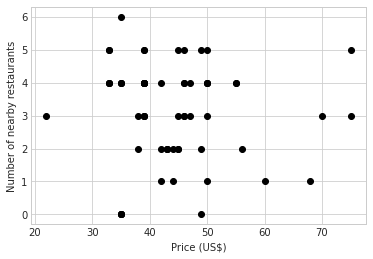

In [36]:
x= df_eastgar['price']
y= df_eastgar['No_of_restaurants']
plt.plot(x, y, 'o', color='black')
plt.xlabel('Price (US$)')
plt.ylabel('Number of nearby restaurants')
plt.show()

In [37]:
code = 'NRJQ2HJ4WRN4U0T4FWOFYWK0VY3QQ5ILKF1JV5GZZFFTB0JJ#_=_'
client_id='3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L'
client_secret = 'A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5'
access_token = 'FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS'

#dataframe = pd.DataFrame()
list =[]

for lat, lng in zip(df_eastgar.latitude, df_eastgar.longitude):
    latitude= lat
    longitude=lng
    url = 'https://api.foursquare.com/v2/venues/search?client_id=3J0WVXDAZKSGHE2CDG0PUSKDGQLAZELIVLNFDTHGVUHP4Y2L&client_secret=A2K5AFROX5LCQMXC2CW5BXCTNLMZBSMCTE2R1GPF15RQD2H5&ll={},{}&auth_token=FNJINUOIESL3AVFZAWUPJOVDX4N1COE33XJKYUZOFBCDNFHS&v=20180604&categoryId=4d4b7105d754a06379d81259&radius=200&limit=50'.format(latitude, longitude)
    results = requests.get(url).json()
    venues = results['response']['venues']
    # tranform venues into a dataframe
    amount = len(venues)
   # print(amount)
    list.append(amount)

df_eastgar['nearby_transport'] = list

df_eastgar.head()

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,No of restaurants,No_of_restaurants,nearby_transport
175,"Clean, Quiet, Private Room with private bathroom",East Garfield Park,41.88152,-87.69768,Private room,45,7,2,138,13,2,2
469,"Teal Room - King Bed, near CTA, 20min to Downtown",East Garfield Park,41.88302,-87.70960,Private room,56,1,9,346,4,2,1
657,"""Wine"" Room - 1 block from train, Victorian Charm",East Garfield Park,41.88302,-87.70960,Private room,49,1,9,309,4,2,1
679,"Vintage Airline - Close to Train, Full Size Bed",East Garfield Park,41.88302,-87.70960,Private room,44,1,9,337,50,2,1
690,"Green Room, Free Parking, King Bed, 1 Block to...",East Garfield Park,41.88302,-87.70960,Private room,43,1,9,328,3,2,1


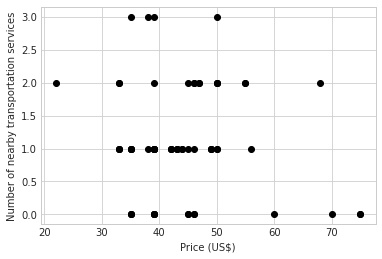

In [38]:
x= df_eastgar['price']
y= df_eastgar['nearby_transport']
plt.plot(x, y, 'o', color='black')
plt.xlabel('Price (US$)')
plt.ylabel('Number of nearby transportation services')
plt.show()

In [ ]:
'''
* kry number of restaurants vir hele df
* kry number of other attractions vir hele dataframe
* delete die ou kak
'''